In [1]:
# Import stuff
import os
import scipy
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

In [2]:
this_dat = np.load('taste_data.npy')
print(this_dat.shape)
# Trial x Nrn x Time

(30, 10, 7000)


In [19]:
# Convert spikes to counts by binning
time_lims = [1500,6000]
bin_width = 50
t_vec = np.arange(this_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(this_dat[...,time_lims[0]:time_lims[1]].reshape(*this_dat.shape[:2],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)

(10, 90)


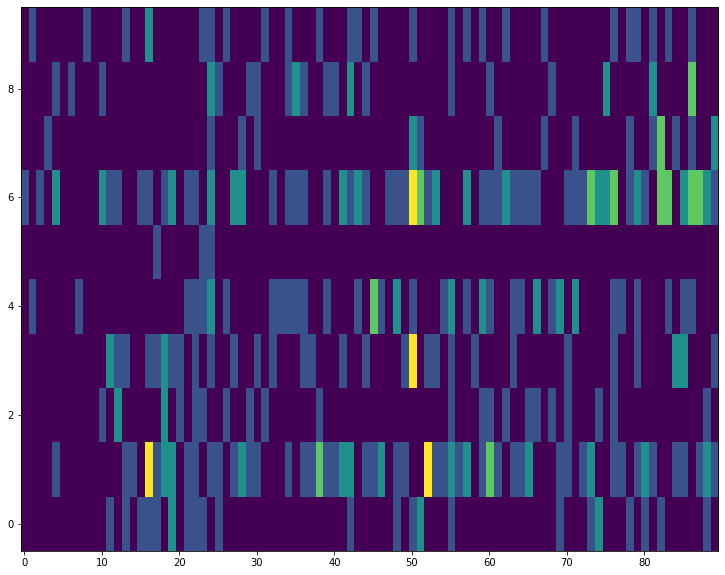

In [20]:
# Pick single trial
trial = 0
count_data = this_dat_binned[trial]
#count_data = np.sum(this_dat_binned,axis=0)
n_count_data = count_data.shape[-1]
plt.imshow(count_data, interpolation = 'nearest', aspect = 'auto', origin = 'lower')
print(count_data.shape)
# Nrn X Time_bin

In [21]:
mean_vals = np.mean(count_data,axis=-1)
print(mean_vals)

[0.27777778 0.84444444 0.25555556 0.41111111 0.48888889 0.03333333
 1.         0.21111111 0.3        0.28888889]


In [22]:
idx = np.arange(n_count_data) # Index
idx_range = idx.max() - idx.min()
print(idx.min())
print(idx.max())

0
89


In [23]:
states = 4
lambda_names = ['lambda_{}'.format(i+1) for i in range(states)]
with pm.Model() as model:
    
    # Defining variables with priors
    alpha = 1.0/count_data.mean(axis=-1)
    
    # Exponential prior on Poisson rate variable: for every state, for every neuron
    #lambda_1 = pm.Exponential("lambda_1", alpha, testval = mean_vals[0], shape = (count_data.shape[0]))
    #lambda_2 = pm.Exponential("lambda_2", alpha, testval = mean_vals[1], shape = (count_data.shape[0]))
    #lambda_3 = pm.Exponential("lambda_3", alpha, testval = mean_vals[1], shape = (count_data.shape[0]))
    lambda_latent = pm.math.stack(
                        [pm.Exponential(lambda_names[i], alpha, testval = mean_vals[1], 
                                   shape = (count_data.shape[0])) \
                         for i in range(states)]
    )
    
print(lambda_latent.tag.test_value.shape)

(4, 10)


In [24]:
with model:
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a = pm.HalfNormal('a_hp', 3.)
    #b = pm.HalfNormal('b_hp', 3.)
    #tau_latent = pm.Beta('tau_latent', a, b)
    #tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Dirichlet prior on switchpoints
    tau_latent = pm.Dirichlet('tau_latent', np.ones(states))[:3] # Gives length of states
    tau = pm.Deterministic('tau', idx_range * tt.extra_ops.cumsum(tau_latent)) # Gives end times of states
    
    
print(tau_latent.tag.test_value)
print(tau.tag.test_value)
    


[0.25 0.25 0.25]
[22.25 44.5  66.75]


In [25]:
with model:
    
    # Assign lambdas to time_bin indices using sigmoids centered on switchpoints
    # Refer to https://www.desmos.com/calculator/yisbydv2cq
    
    #weight_0 = tt.nnet.sigmoid(2 * (idx - 0))
    weight_1 = tt.nnet.sigmoid(2 * (idx - tau[0])) # First state ends at tau[0]
    weight_2 = tt.nnet.sigmoid(2 * (idx - tau[1])) # Second state ends at tau[1]
    weight_3 = tt.nnet.sigmoid(2 * (idx - tau[2])) # Third state ends at tau[2]
    #weight_4 = tt.nnet.sigmoid(2 * (idx - tau[3])) # Fourth state ends at tau[3]
    #weight_list = [tt.nnet.sigmoid(2 * (idx - tau[i])) for i in range(len(tau))]
    #weight_list = [tt.nnet.sigmoid(2 * (idx - 0)))] + weight_list
    
    
    #lambda_ = pm.math.stack(
    #            [ (weight_0 * (1 - weight_1) * lambda_1[i]) + \
    #              (weight_1 * (1 - weight_2) * lambda_2[i]) + \
    #              (weight_2 * (1 - weight_3) * lambda_3[i])
    #             for i in range(count_data.shape[0])]
    #                    )
    
    lambda_ = pm.math.stack(
            [ (1 - weight_1) * lambda_latent[0][i] + \
              (weight_1 * (1 - weight_2) * lambda_latent[1][i]) + \
              (weight_2 * (1 - weight_3) * lambda_latent[2][i]) + \
              (weight_3 * lambda_latent[3][i])
             for i in range(count_data.shape[0])]
                    )
    
print(lambda_.tag.test_value.shape)

(10, 90)


In [26]:
# Using poisson likelihood for count data
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)
    

In [27]:
with model:
    #step = pm.Metropolis()
    #trace = pm.sample(15000, tune=5000,step=step)
    trace = pm.sample(15000, tune=5000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau_latent, lambda_4, lambda_3, lambda_2, lambda_1]
Sampling 4 chains, 10 divergences: 100%|██████████| 80000/80000 [08:20<00:00, 159.91draws/s]
The acceptance probability does not match the target. It is 0.6238434444352131, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9477595688787005, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3062212164073755, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.3767117110201564, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.0

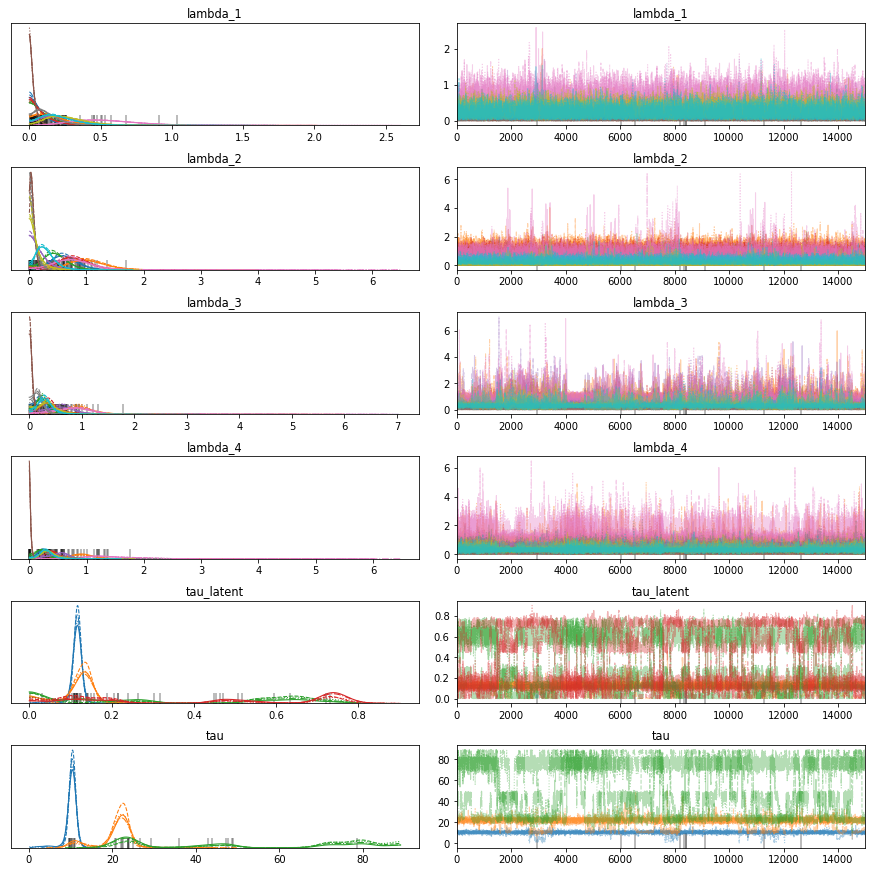

In [28]:
pm.traceplot(trace);

In [29]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_1[0],0.08,0.08,0.00,0.21,0.00,0.00,8995.0,8724.0,7056.0,4842.0,1.00
lambda_1[1],0.17,0.12,0.00,0.38,0.00,0.00,14145.0,11163.0,12307.0,7918.0,1.00
lambda_1[2],0.10,0.09,0.00,0.26,0.00,0.00,11961.0,11961.0,8858.0,8315.0,1.00
lambda_1[3],0.09,0.09,0.00,0.25,0.00,0.00,11375.0,11375.0,7717.0,5640.0,1.00
lambda_1[4],0.23,0.14,0.02,0.48,0.00,0.00,11680.0,11680.0,9722.0,9100.0,1.00
lambda_1[5],0.02,0.02,0.00,0.07,0.00,0.00,16571.0,16571.0,10055.0,8039.0,1.00
lambda_1[6],0.54,0.23,0.16,0.97,0.00,0.00,11408.0,11043.0,11343.0,14044.0,1.00
lambda_1[7],0.13,0.09,0.00,0.30,0.00,0.00,11614.0,11614.0,10028.0,10317.0,1.00
lambda_1[8],0.26,0.14,0.04,0.53,0.00,0.00,10743.0,10743.0,8502.0,7352.0,1.00
lambda_1[9],0.21,0.12,0.02,0.43,0.00,0.00,13626.0,13626.0,11641.0,9335.0,1.00


In [30]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
lambda_3_samples = trace['lambda_3']
lambda_4_samples = trace['lambda_4']
lambda_stack = np.stack([lambda_1_samples,
                            lambda_2_samples,
                            lambda_3_samples,
                            lambda_4_samples])
tau_samples = trace['tau']
print(tau_samples.shape)
print(lambda_stack.shape)

(60000, 3)
(4, 60000, 10)


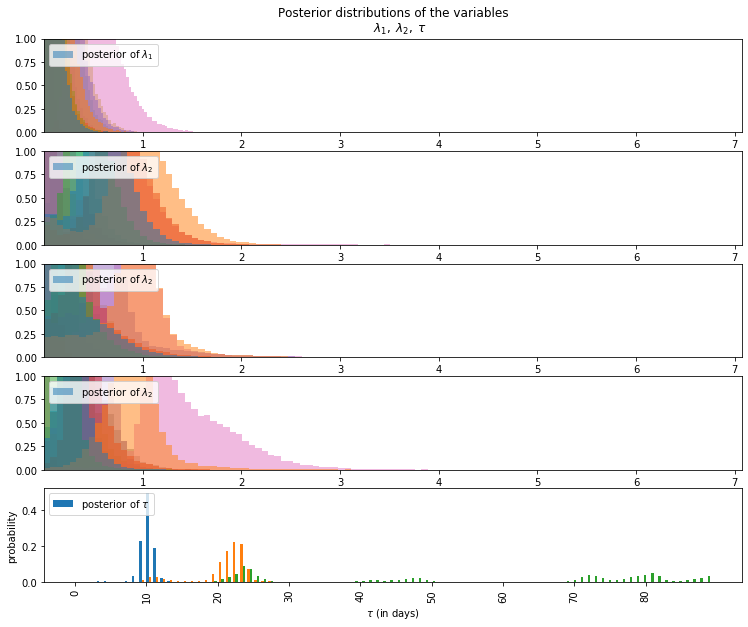

In [31]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(511)
ax.set_autoscaley_on(False)

x_lims = [min(lambda_stack.flatten()),max(lambda_stack.flatten())]
bin_num = 100

plt.hist(lambda_1_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_1$", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")
plt.xlim(x_lims)

ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim(x_lims)

ax = plt.subplot(513)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim(x_lims)

ax = plt.subplot(514)
ax.set_autoscaley_on(False)
plt.hist(lambda_4_samples, histtype='stepfilled', bins=bin_num, alpha=0.5,
         label="posterior of $\lambda_2$", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim(x_lims)

plt.subplot(515)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data,step=10))


plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.xticks(rotation='vertical')
plt.ylabel("probability");

In [32]:
ppc = pm.sample_posterior_predictive(trace, samples = 10000, model = model)
ppc['obs'].shape

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [01:38<00:00, 101.06it/s]


(10000, 10, 90)

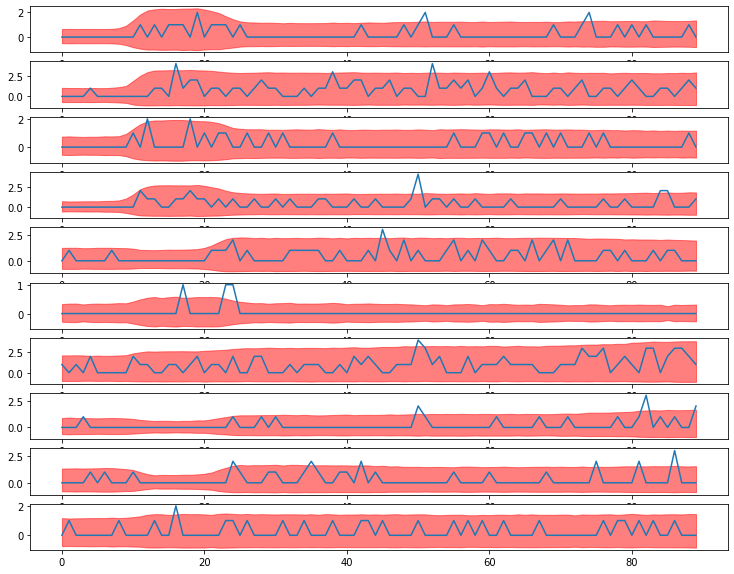

In [33]:
mean_ppc = np.mean(ppc['obs'],axis=0)
std_ppc = np.std(ppc['obs'],axis=0)

x = np.arange(count_data.shape[-1])
fig, ax = plt.subplots(count_data.shape[0],1, sharey = False)
for num,(nrn,this_ax) in enumerate(zip(count_data, ax.flatten())):
    this_ax.plot(x,nrn);
    this_ax.fill_between( x = x,
                        y1 = mean_ppc[num] + 2*std_ppc[num],
                        y2 = mean_ppc[num] - 2*std_ppc[num],
                        color = 'red', alpha = 0.5);
#plt.plot(np.mean(ppc['obs'],axis=0));
#traces = 100
#plt.plot(ppc['obs'][:100].T, alpha = 0.05);

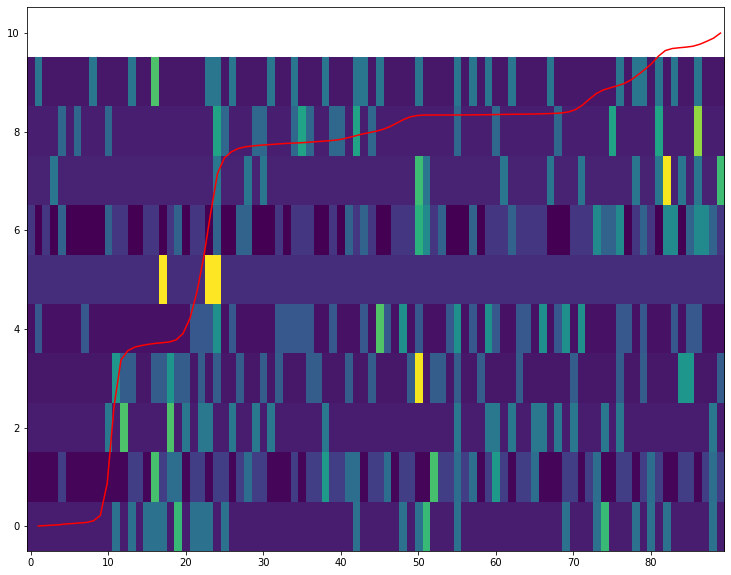

In [34]:
# Overlay raster with CDF of switchpoints
plt.imshow(stats.zscore(count_data,axis=-1),interpolation='nearest',aspect='auto',origin='lower')
fin_prob,this_x = np.histogram(tau_samples.flatten(),100)
cum_prob = np.cumsum(fin_prob)
plt.plot(this_x[1:],cum_prob/np.max(cum_prob)*count_data.shape[0], c = 'red')